In [1]:
# Modelinging homogeneity data 
import pandas as pd
import numpy as np
filepath = "homo_sel.csv"
data_homo = pd.read_csv(filepath)
if 'Unnamed: 0' in data_homo.columns:
    data_homo = data_homo.drop(['Unnamed: 0'],axis=1)   
#print(data_homo.head(10))

Reading data from file

In [60]:
C_h,radius_h,angle_h = np.histogram2d(data_homo['radius'],data_homo['angle'],bins=[np.arange(0,26,1),np.arange(0,365,5)])
angle_h = np.delete(angle_h,-1)
radius_h = np.delete(radius_h,-1)
angle_c = [i + 2.5 for i in angle_h]
radius_c = [i + .5 for i in radius_h]
#print(len(angle_h))
#print(len(radius_c))
pos_x = []
pos_y = []
C_c = []
for i in range(len(radius_c)):
    for j in range(len(angle_c)):
        pos_x.append(radius_c[i]*np.cos(angle_c[j]*np.pi/180))
        pos_y.append(radius_c[i]*np.sin(angle_c[j]*np.pi/180))
        C_c.append(C_h[i][j])
pos_h = np.stack((pos_x,pos_y),axis=-1)
print(np.mean(C_c)) #Average count of 1800 areas
print(1/np.sqrt(np.mean(C_c)))
print(np.std(C_c)/np.mean(C_c))
#print(len(pos_x))
#print(C_h[1])

51.22666666666667
0.13971786846853534
0.4903867817016568


Making counts of each area corresponding to central position.

72
Matern(length_scale=9.3, nu=1.5)
-52563.74172981297


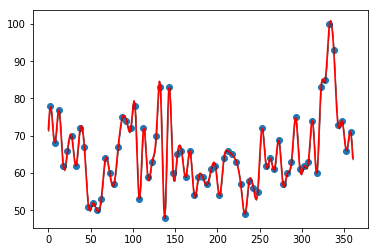

In [63]:
import matplotlib.pyplot as plt
plt.scatter(angle_c,C_h[6])
#print(len(angle_c))
angle_c_f = np.atleast_2d(angle_c).T
print(len(angle_c_f))
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern,RBF,WhiteKernel
xx, yy = np.meshgrid(np.linspace(-25, 25, 50),
                     np.linspace(-25, 25, 50))
pos_all = np.vstack((xx.ravel(), yy.ravel()))
x = np.linspace(0, 360, 360)
#kernel_a = RBF(length_scale=1.0)
kernel_a = Matern()
clf_a = GaussianProcessRegressor(kernel=kernel_a,n_restarts_optimizer=9).fit(angle_c_f,C_h[6])
C_pred,sigma_pred = clf_a.predict(np.atleast_2d(x).T,return_std=True)
C_pred = C_pred.reshape(x.shape)
#sigma_pred = sigma_pred.reshape(xx.shape)0

print(clf_a.kernel_)
#print(clf_a.alpha_)
print(clf_a.log_marginal_likelihood_value_)
#print(len(C_pred))
plt.plot(x, C_pred, 'r-', label='Prediction')
plt.fill_between(x, C_pred - sigma_pred,
                 C_pred + sigma_pred,
                 alpha=0.5, color='k')
plt.show()

One dimensional GP is implemented to model counts versus angles. Very good result.
Next step is to do two dimensional gaussain process in XY- coordinate.

1800
Matern(length_scale=0.688, nu=1.5)


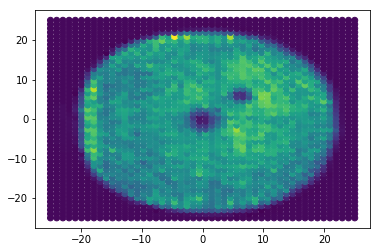

In [64]:
kernel_2d = Matern()#+RBF()
#print(len(pos_h))
print(len(C_c))
clf_2d = GaussianProcessRegressor(kernel=kernel_2d,n_restarts_optimizer=9).fit(pos_h,C_c)
C_2d_pred,std_2d_pred = clf_2d.predict(pos_all.T,return_std=True)
print(clf_2d.kernel_)
#print(C_2d_pred)
#print(std_2d_pred)
plt.scatter(pos_all.T[:,0],pos_all.T[:,1],c=C_2d_pred)
plt.show()

[  4.59183673 -12.75510204]
57.756417179458474
0.6809679008406236
[5.6122449  7.65306122]
39.42488924341508
0.3671452224834387
[5.6122449  6.63265306]
14.434398445468862
0.5064926214032368
[ 6.34592405 -1.40685749]


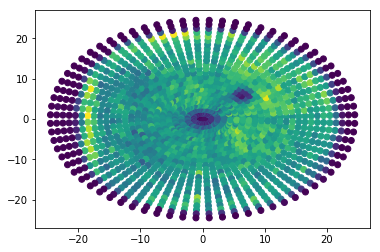

In [66]:
print(pos_all.T[629])
print(C_2d_pred[629])
print(std_2d_pred[629])
print(pos_all.T[1630])
print(C_2d_pred[1630])
print(std_2d_pred[1630])
print(pos_all.T[1580])
print(C_2d_pred[1580])
print(std_2d_pred[1580])
plt.scatter(pos_h[:,0],pos_h[:,1],c=C_c)
print(pos_h[501])
plt.show()

2500
-25.0


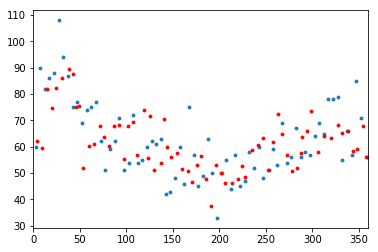

In [67]:
x_center = 0.909
y_center = -1.364
pos_gp = []
C_pred_f = []
pos_s =[]
for i in range(len(pos_all.T)):
    if pos_all.T[i][1]-y_center >0:
        angle_tem = np.arctan2(pos_all.T[i][1]-y_center, pos_all.T[i][0]-x_center)*180/np.pi
    else:
        angle_tem = np.arctan2(pos_all.T[i][1]-y_center, pos_all.T[i][0]-x_center)*180/np.pi + 360
    radius_tem = np.sqrt(np.square(pos_all.T[i][1]-y_center)+np.square(pos_all.T[i][0]-x_center))
    pos_gp.append([radius_tem,angle_tem])
    if radius_tem > 11 and radius_tem <12:
        pos_s.append(angle_tem)
        C_pred_f.append(C_2d_pred[i])
#print(pos_gp)
plt.scatter(angle_c,C_h[11],s=8)
print(len(pos_all.T))
print(pos_all.T[1][1])
plt.scatter(pos_s,C_pred_f,c='r',s=8)
plt.xlim(0,360)
plt.show()